En este notebook vamos a realizar distintos métodos de feature engineering y preprocesamiento sobre el set de datos, para ver si conseguimos un modelo que prediga mejor.

## Librerias

In [2]:
import pandas as pd
from datetime import datetime
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, RobustScaler

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import warnings
warnings.filterwarnings("ignore")

## Carga de datos

In [3]:
df_2 = pd.read_csv("..\\data\\processed\\feature_engeering.csv", index_col=0, parse_dates=["date"])

In [4]:
df_2

,date,rank,repo_name,stars,forks,username,issues,description,days_since_lc,repos_by_user
0,2018-12-18,1,awesome-python,58777,11448,3209,439,"A curated list of awesome Python frameworks, l...",5.0,1.0
1,2018-12-19,1,awesome-python,58801,11454,3209,439,"A curated list of awesome Python frameworks, l...",6.0,1.0
2,2018-12-20,1,awesome-python,58840,11455,3209,439,"A curated list of awesome Python frameworks, l...",0.0,1.0
3,2018-12-21,1,awesome-python,58882,11465,3209,440,"A curated list of awesome Python frameworks, l...",1.0,1.0
4,2018-12-22,1,awesome-python,58936,11470,3209,439,"A curated list of awesome Python frameworks, l...",2.0,1.0
...,...,...,...,...,...,...,...,...,...,...
168682,2024-01-30,33,gpt-engineer,48777,7923,1581,20,"Specify what you want it to build, the AI asks...",2.0,1.0
168683,2024-01-31,35,gpt-engineer,48787,7930,1581,20,"Specify what you want it to build, the AI asks...",1.0,1.0
168684,2024-02-01,38,gpt-engineer,48800,7929,1581,21,"Specify what you want it to build, the AI asks...",1.0,1.0
168685,2024-02-02,38,gpt-engineer,48822,7931,1581,21,"Specify what you want it to build, the AI asks...",1.0,1.0


## Sentiment Analysis

In [5]:
sia = SentimentIntensityAnalyzer()

In [6]:
res = {}

for i, x in df_2.iterrows():
    des = x["description"]
    repo_name = x["repo_name"]
    res[repo_name] = sia.polarity_scores(des)

In [7]:
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={"index":"repo_name"})
vaders = vaders.merge(df_2, how="left")

In [8]:
vaders.head()

,repo_name,neg,neu,pos,compound,date,rank,stars,forks,username,issues,description,days_since_lc,repos_by_user
0,awesome-python,0.0,0.687,0.313,0.6249,2018-12-18,1,58777,11448,3209,439,"A curated list of awesome Python frameworks, l...",5.0,1.0
1,awesome-python,0.0,0.687,0.313,0.6249,2018-12-19,1,58801,11454,3209,439,"A curated list of awesome Python frameworks, l...",6.0,1.0
2,awesome-python,0.0,0.687,0.313,0.6249,2018-12-20,1,58840,11455,3209,439,"A curated list of awesome Python frameworks, l...",0.0,1.0
3,awesome-python,0.0,0.687,0.313,0.6249,2018-12-21,1,58882,11465,3209,440,"A curated list of awesome Python frameworks, l...",1.0,1.0
4,awesome-python,0.0,0.687,0.313,0.6249,2018-12-22,1,58936,11470,3209,439,"A curated list of awesome Python frameworks, l...",2.0,1.0


<Axes: xlabel='compound', ylabel='Count'>

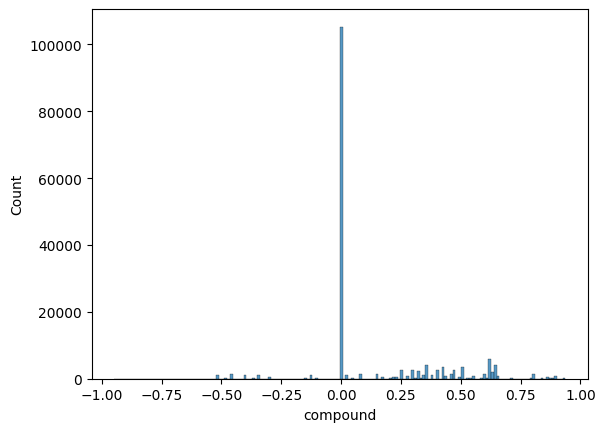

In [9]:
sns.histplot(data=vaders, x = "compound")

<Axes: xlabel='neu', ylabel='Count'>

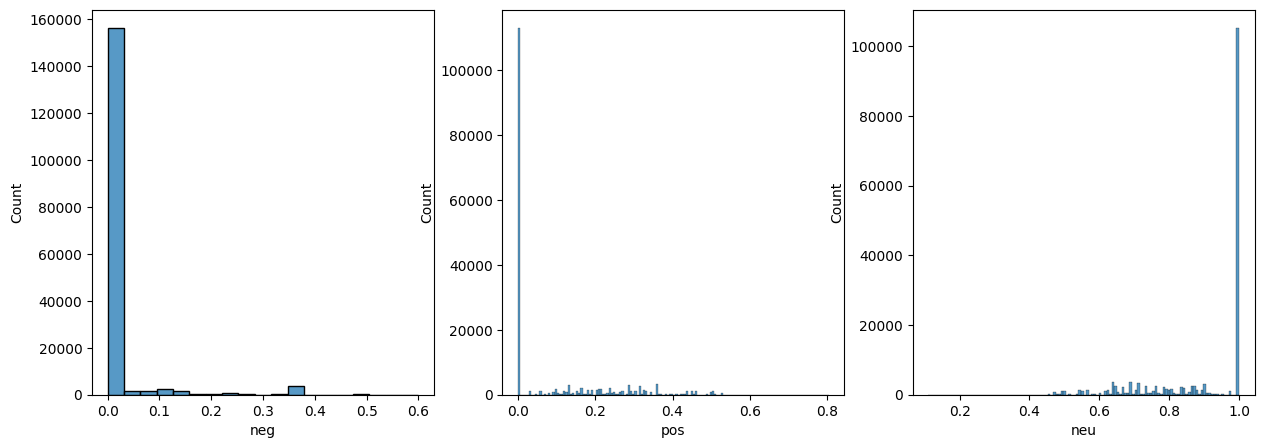

In [10]:
fig, axs = plt.subplots(1,3, figsize=(15, 5))

sns.histplot(data=vaders, x = "neg", ax=axs[0])
sns.histplot(data=vaders, x = "pos", ax=axs[1])
sns.histplot(data=vaders, x = "neu", ax=axs[2])

<Axes: xlabel='neu', ylabel='Count'>

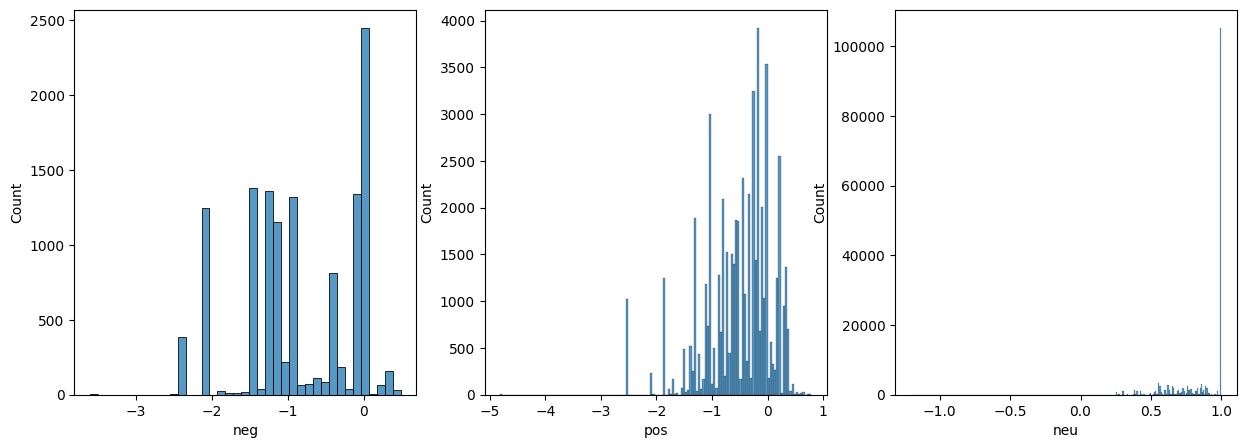

In [11]:
fig, axs = plt.subplots(1,3, figsize=(15, 5))

sns.histplot(data=vaders, x = np.log(vaders["neg"]) +1, ax=axs[0])
sns.histplot(data=vaders, x = np.log(vaders["pos"]) +1, ax=axs[1])
sns.histplot(data=vaders, x = np.log(vaders["neu"]) +1, ax=axs[2])

## Aplicando el resto de tramsformaciones

### Label Enconder y Robust escaler

In [12]:
df_3 = vaders.drop(columns=["description"])

le = LabelEncoder()
df_3["repo_name"] = le.fit_transform(df_3["repo_name"])

df_3["day"] = df_3["date"].dt.day
df_3["month"] = df_3["date"].dt.month
df_3["year"] = df_3["date"].dt.year
df_3.drop(columns="date", inplace=True)

RobEsc = RobustScaler()
esc_features = RobEsc.fit_transform(df_3)
df_3[['repo_name','neg', 'neu', 'pos', 'compound', 'rank', 'stars', 'forks', 'username', 'issues', 'days_since_lc', 'repos_by_user', 'day', 'month',
       'year']] = esc_features


<Axes: >

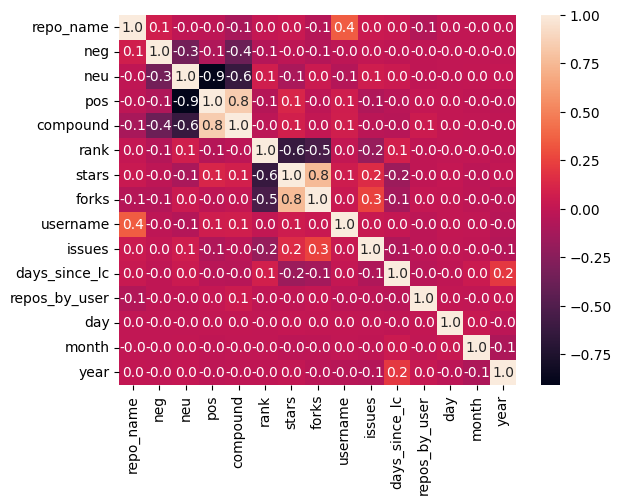

In [13]:
sns.heatmap(df_3.corr(), annot=True, fmt=".1f")

In [14]:
df_3.drop(columns=['neg', 'neu', 'pos'], inplace=True)

## División train y test

In [15]:
train, test = train_test_split(df_3, test_size=0.2, random_state=42)

In [16]:
train.to_csv("..\\data\\processed\\train_sentiment.csv")
test.to_csv("..\\data\\processed\\test_sentiment.csv")

## sin eliminar description

In [17]:
df_4 = vaders.copy()

le = LabelEncoder()
for x in df_4[["repo_name", "description"]].columns:
    df_4[x] = le.fit_transform(df_4[x])

df_4["day"] = df_4["date"].dt.day
df_4["month"] = df_4["date"].dt.month
df_4["year"] = df_4["date"].dt.year
df_4.drop(columns="date", inplace=True)

RobEsc = RobustScaler()
esc_features = RobEsc.fit_transform(df_4)
df_4[['repo_name','neg', 'neu', 'pos', 'compound', 'rank', 'stars', 'forks', 'username', 'issues', 'description','days_since_lc', 'repos_by_user', 'day', 'month',
       'year']] = esc_features


In [18]:
df_4.drop(columns=['neg', 'neu', 'pos'], inplace=True)

In [19]:
train, test = train_test_split(df_3, test_size=0.2, random_state=42)
train.to_csv("..\\data\\processed\\train_sentiment_2.csv")
test.to_csv("..\\data\\processed\\test_sentiment_2.csv")